# Preparing a spectrum for Sculptor modeling using the SpecOneD class
In this example we will be preparing two optical and one near-infrared spectrum for further spectral modeling using the Sculptor GUI. The spectra are of the ultra-luminous quasar J2125-1719 and are published in [Schindler et al. 2020](https://ui.adsabs.harvard.edu/abs/2021ApJ...906...12S/abstract).

First, we import the SpecOneD module from Sculptor and read in the three spectra from the example folder. 

In [1]:
from sculptor import speconed as sod

from astropy import units as u

# Read in the spectra of J2125-1719 
specnir = sod.SpecOneD()
specnir.read_pypeit_fits('../../sculptor/data/example_spectra/J2125-1719_NIR.fits')
specoptA = sod.SpecOneD()
specoptA.read_from_fits('../../sculptor/data/example_spectra/J2125-1719_OPT_A.fits')
specoptB = sod.SpecOneD()
specoptB.read_from_fits('../../sculptor/data/example_spectra/J2125-1719_OPT_B.fits')

# The optical spectra will be scaled to 1e-17 erg/s/cm^2/A
specoptA.convert_spectral_units(1.*u.AA, 1e-17*u.erg/u.s/u.cm**2/u.AA)
specoptB.convert_spectral_units(1.*u.AA, 1e-17*u.erg/u.s/u.cm**2/u.AA)

We could use SpecOneD's plot function to look at the spectra individually, but in this case we want to use matplotlib to show all spectra in one plot. 

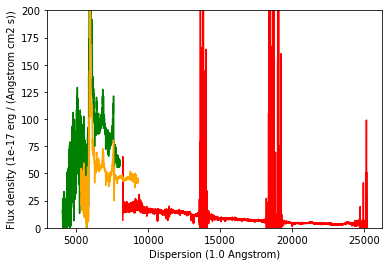

In [2]:
import matplotlib.pyplot as plt

plt.plot(specnir.dispersion, specnir.fluxden, 'red')
plt.plot(specoptA.dispersion, specoptA.fluxden, 'green')
plt.plot(specoptB.dispersion, specoptB.fluxden, 'orange')
plt.ylim(0, 200)
plt.xlabel('Dispersion ({})'.format(specnir.dispersion_unit))
plt.ylabel('Flux density ({})'.format(specnir.fluxden_unit))
plt.show()

## Deredden the science spectrum 
According to the IRSA dust map (https://irsa.ipac.caltech.edu/applications/DUST/) the quasar J2125-1719 (21h25m40.97s -17d19m51.3s Equ J2000) has a A_V=0.1606 using to the Schlafly & Finkbeiner 2011 (ApJ 737, 103) Galactic dust map.

As we use the dereddened magnitudes for flux normalization we apply the deredden the three individual spectra before.

We demonstrate how one would use the speconed module to "deredden" the spectrum using the Fitzpatrick & Massa 2007 extinction curve. To do this speconed uses the python extinction package (https://github.com/kbarbary/extinction).


[Warning] For Fitzpatrick & Massa 2007 R_V=3.1
[Warning] For Fitzpatrick & Massa 2007 R_V=3.1
[Warning] For Fitzpatrick & Massa 2007 R_V=3.1


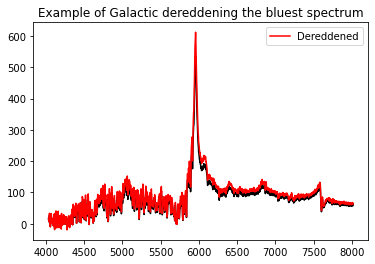

In [3]:
a_v = 0.1606
r_v = 3.1
specnir = specnir.remove_extinction(a_v, r_v, extinction_law='fm07')

plt.plot(specoptA.dispersion, specoptA.fluxden,'k')

specoptA = specoptA.remove_extinction(a_v, r_v, extinction_law='fm07')
specoptB = specoptB.remove_extinction(a_v, r_v, extinction_law='fm07')


plt.plot(specoptA.dispersion, specoptA.fluxden,'r', label='Dereddened')
plt.legend()
plt.title('Example of Galactic dereddening the bluest spectrum')
plt.show()

## Normalizing the spectral fluxes to measured magnitudes
It is evident that the flux normalization of the three spectra does not agree with another. For a first test we will now scale the spectra according to their broad band magnitudes. 

### Normalizing the near-infrared spectrum
We will start with the near-infrared spectrum, for which 2MASS magnitudes are available. In AB the magnitudes are J=16.13, H=16.14, K=16.01. We will begin by loading the 2MASS passbands.

(A range of passbands are included already with the Sculptor package in sculptor/data/passbands. The PassBand class behaves very similar to the SpecOneD class, but is mainly used for calculating magnitudes from spectra. The passbands can also be plotted like SpecOneD objects, e.g. 'pb_r.plot()') 

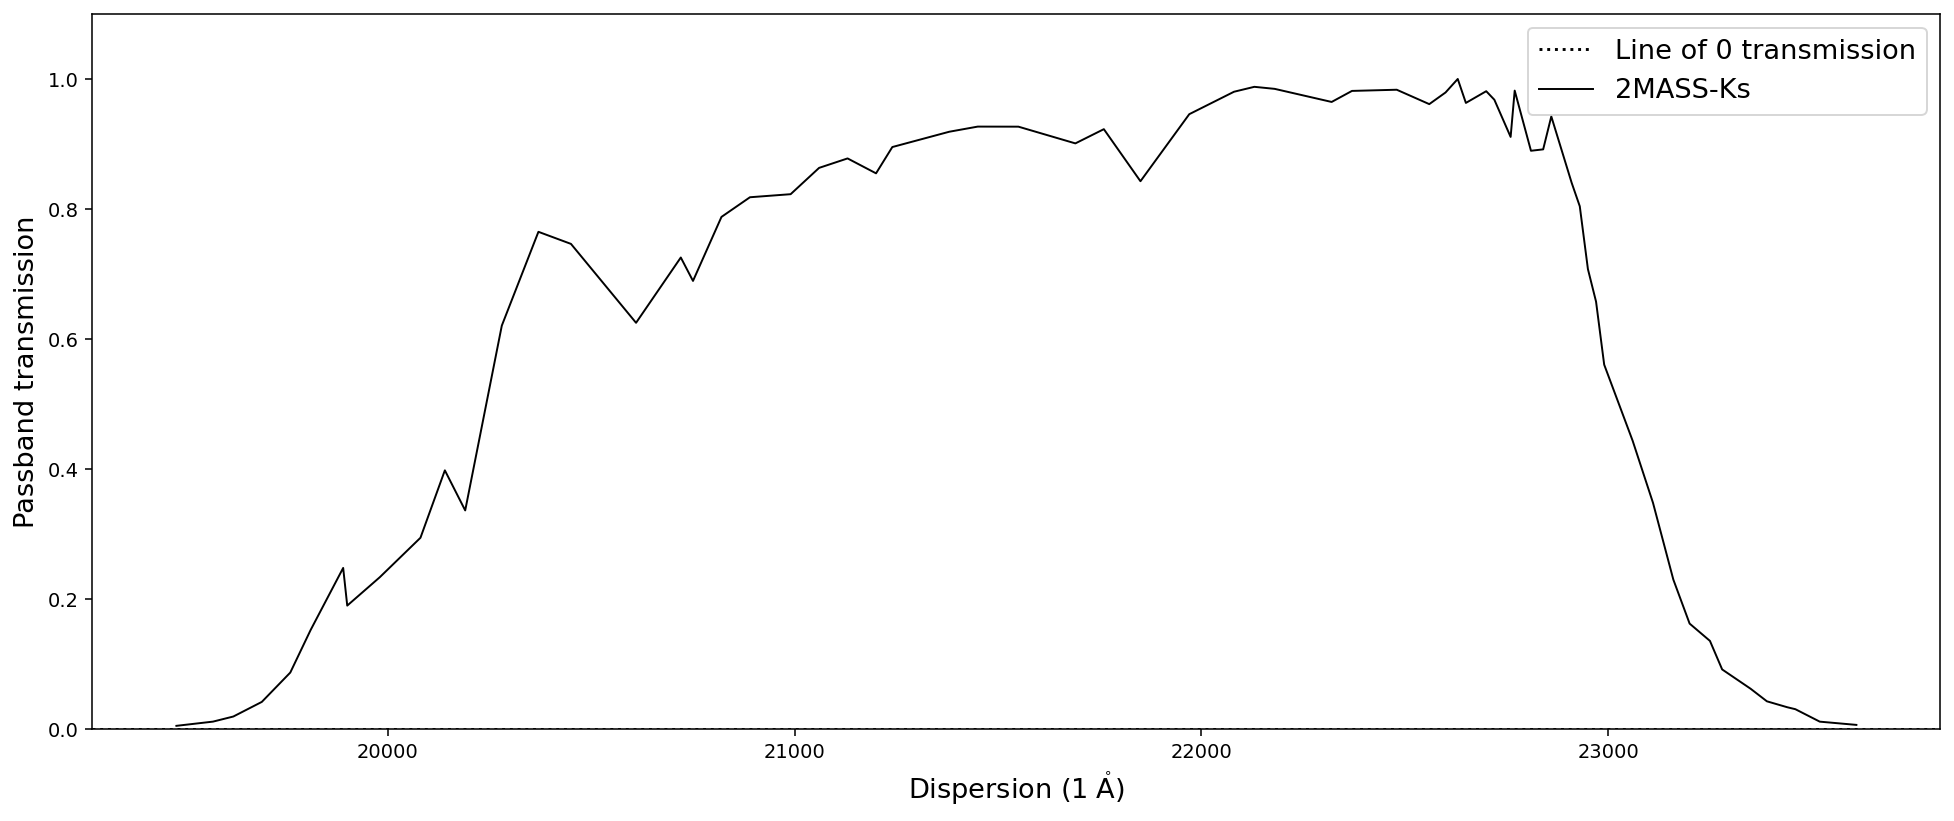

In [4]:
pb_J = sod.PassBand(passband_name='2MASS-J')
pb_H = sod.PassBand(passband_name='2MASS-H')
pb_Ks = sod.PassBand(passband_name='2MASS-Ks')

pb_Ks.plot()

As a test, let us calculate the magnitudes of the spectrum in the three 2MASS filter before flux normalization.

In [5]:
J_ab_before = specnir.calculate_passband_ab_magnitude(pb_J)
H_ab_before = specnir.calculate_passband_ab_magnitude(pb_H)
Ks_ab_before = specnir.calculate_passband_ab_magnitude(pb_Ks)
print('J_AB = {:.2f}'.format(J_ab_before))
print('H_AB = {:.2f}'.format(H_ab_before))
print('Ks_AB = {:.2f}'.format(Ks_ab_before))

J_AB = 16.76
H_AB = 16.79
Ks_AB = 16.89


We are now choosing the K-band magnitude for the flux normalization as the overlap region between the band and the spectrum is least affected by telluric features. Then we recalculate the magnitudes of the spectrum in the three 2MASS filter bands.

In [6]:
Ks_ab = 16.01
J_ab = 16.13
H_ab = 16.14
nspecnir = specnir.renormalize_by_ab_magnitude(Ks_ab, pb_Ks)

J_ab_after = nspecnir.calculate_passband_ab_magnitude(pb_J)
H_ab_after = nspecnir.calculate_passband_ab_magnitude(pb_H)
Ks_ab_after = nspecnir.calculate_passband_ab_magnitude(pb_Ks)
print('J_AB = {:.2f}'.format(J_ab_after))
print('H_AB = {:.2f}'.format(H_ab_after))
print('Ks_AB = {:.2f}'.format(Ks_ab_after))

J_AB = 15.89
H_AB = 15.92
Ks_AB = 16.01


Let us now compare the magnitude differences between the J-, H-band magnitudes from before and after the normalization. The choice of the K-band is furthermore motivated by a comparison of the near-infrared with the optical spectra after all have been normalized to broad band fluxes (see below).

In [7]:
print('Absolute J-band differences before and after normalization: {:.2f} mag vs {:.2f} mag'.format(
    abs(J_ab_before-J_ab), abs(J_ab_after-J_ab)))
print('Absolute H-band differences before and after normalization: {:.2f} mag vs {:.2f} mag'.format(
    abs(H_ab_before-H_ab), abs(H_ab_after-H_ab)))
print('Absolute Ks-band differences before and after normalization: {:.2f} mag vs {:.2f} mag'.format(
    abs(Ks_ab_before-Ks_ab), abs(Ks_ab_after-Ks_ab)))

Absolute J-band differences before and after normalization: 0.63 mag vs 0.24 mag
Absolute H-band differences before and after normalization: 0.65 mag vs 0.22 mag
Absolute Ks-band differences before and after normalization: 0.88 mag vs 0.00 mag


While the K-band flux normalization leaves some residuals in the J- and H-bands, the are much closer to their 2MASS values than before. 

### Normalizing the optical spectra
We now continue with the optical spectra, starting with the green spectrum (specoptA) and use the Pan-STARRS r-band magnitude (r=16.50, AB) for normalization.

In [8]:
r_ab = 16.50
pb_r = sod.PassBand(passband_name='PS1-r')
nspecoptA = specoptA.renormalize_by_ab_magnitude(r_ab, pb_r)

The orange spectrum (specoptB) starts and ends at larger wavelengths. Therefore, we use the Pan-STARRS i-band magnitude (i=16.42, AB) for normalization.

In [9]:
i_ab = 16.50
pb_i = sod.PassBand(passband_name='PS1-i')
nspecoptB = specoptB.renormalize_by_ab_magnitude(i_ab, pb_i)

### Normalized spectra

Below we display the spectra normalized by their broad band r, i, and Ks photometry. A comparison to the previous figure displays that the broad band flux normalization has been successful.

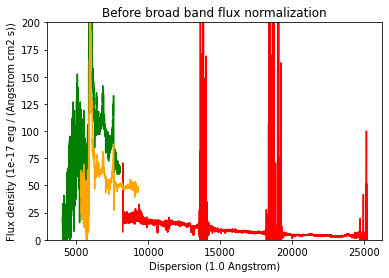

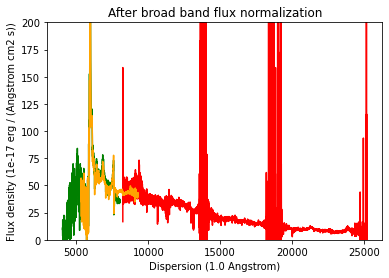

In [10]:
import matplotlib.pyplot as plt

plt.plot(specnir.dispersion, specnir.fluxden, 'red')
plt.plot(specoptA.dispersion, specoptA.fluxden, 'green')
plt.plot(specoptB.dispersion, specoptB.fluxden, 'orange')
plt.ylim(0, 200)
plt.xlabel('Dispersion ({})'.format(specnir.dispersion_unit))
plt.ylabel('Flux density ({})'.format(specnir.fluxden_unit))
plt.title('Before broad band flux normalization')
plt.show()

plt.plot(nspecnir.dispersion, nspecnir.fluxden, 'red')
plt.plot(nspecoptA.dispersion, nspecoptA.fluxden, 'green')
plt.plot(nspecoptB.dispersion, nspecoptB.fluxden, 'orange')
plt.ylim(0, 200)
plt.xlabel('Dispersion ({})'.format(nspecnir.dispersion_unit))
plt.ylabel('Flux density ({})'.format(nspecnir.fluxden_unit))
plt.title('After broad band flux normalization')
plt.show()

## Building a composite spectrum

To model the quasar spectrum In the next step we will very crudely "stitch" the spectra together using the normalized K-band spectrum as a reference. 
In a first step we renomalize the flux level of the optical spectrum B to the broad band normalized near-infrared spectrum in their overlap wavelength range 8500-9000 A. 

In [11]:
nspecoptB = specoptB.renormalize_by_spectrum(nspecnir, dispersion_limits=[8500, 9000])

Then we normalize the optical spectrum A to the normalized optical spectrum B in their overlap wavelength range 6000-7000 A.

In [12]:
nspecoptA = specoptA.renormalize_by_spectrum(nspecoptB, dispersion_limits=[6000, 7000])

Now that the spectra have the save flux level in their overlap regions, we trim their dispersion axes before we stitch them together.

[WARNING] Lower limit is below the lowest dispersion value. The lower limit is set to the minimum dispersion value.
[WARNING] Upper limit is above the highest dispersion value. The upper limit is set to the maximum dispersion value.


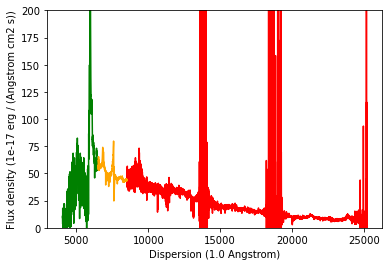

In [13]:
nspecoptA = nspecoptA.trim_dispersion([0,6500])
nspecoptB = nspecoptB.trim_dispersion([6500,8500])
nspecnir = nspecnir.trim_dispersion([8500,400000])

# Lets. plot them to have a quick look.
plt.plot(nspecnir.dispersion, nspecnir.fluxden, 'red')
plt.plot(nspecoptA.dispersion, nspecoptA.fluxden, 'green')
plt.plot(nspecoptB.dispersion, nspecoptB.fluxden, 'orange')
plt.ylim(0, 200)
plt.xlabel('Dispersion ({})'.format(nspecnir.dispersion_unit))
plt.ylabel('Flux density ({})'.format(nspecnir.fluxden_unit))
plt.show()

This doesn't look too bad. Now we build the composite spectrum by appending all dispersion, flux density, and flux density error arrays. This is done manually. Possibly, future versions of Sculptor may be able to automatize this process.

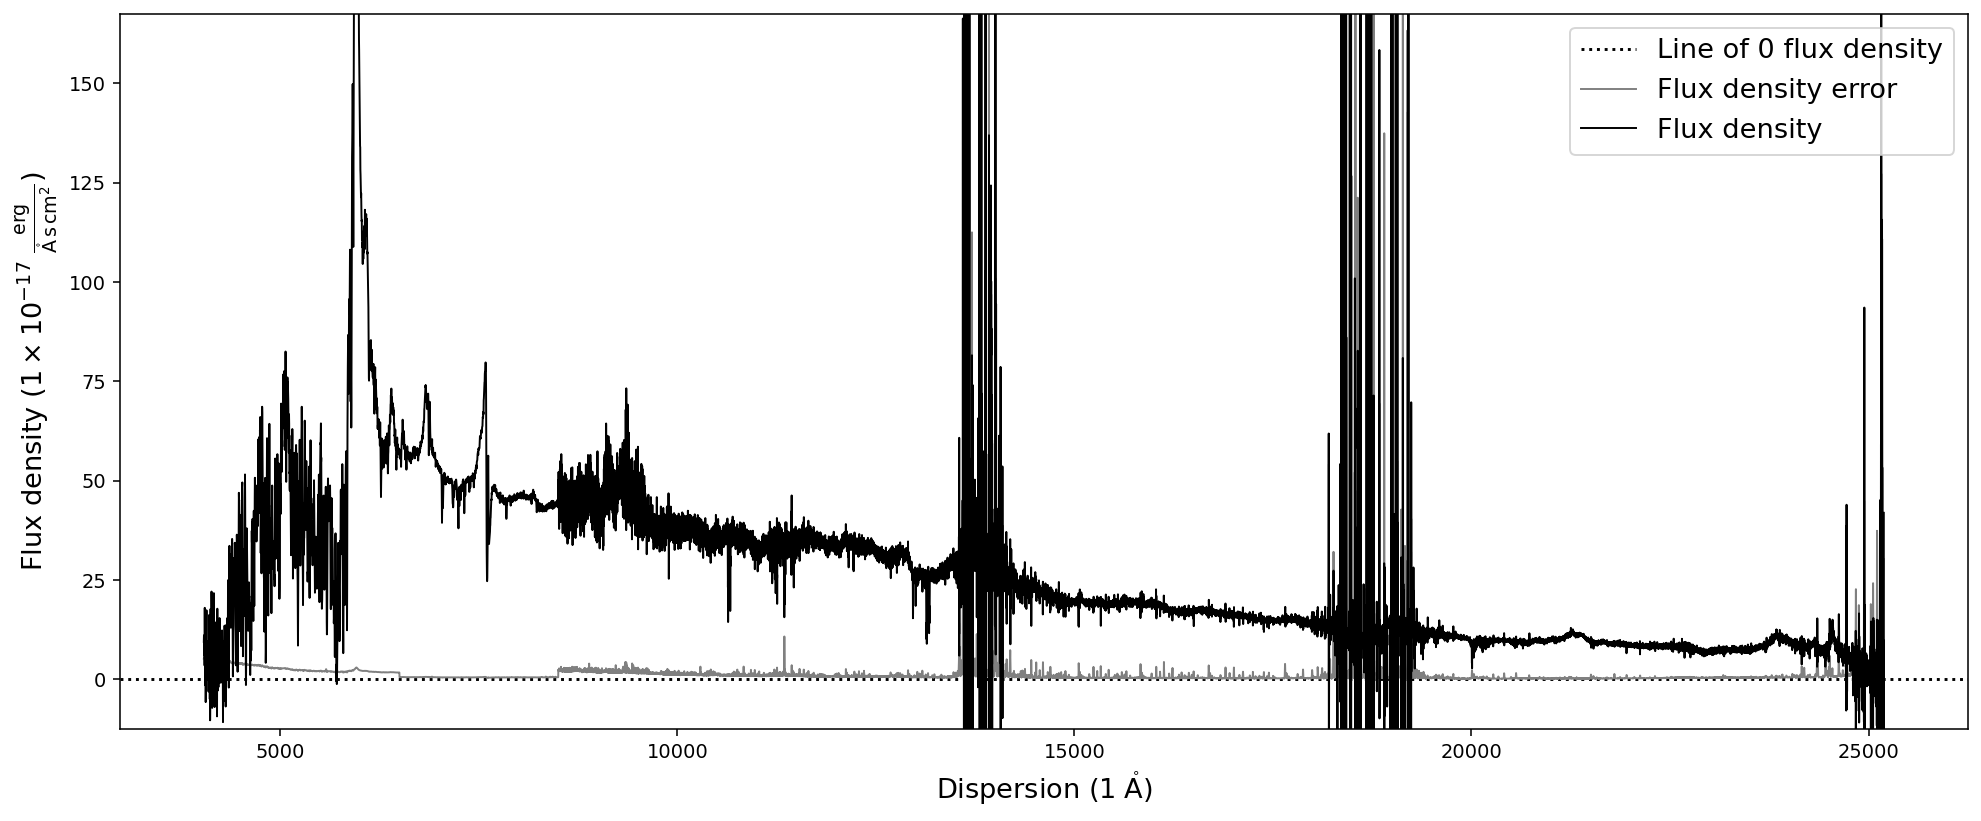

In [14]:
import numpy as np

# Building the dispersion array
comp_dispersion = nspecoptA.dispersion
comp_dispersion = np.append(comp_dispersion, nspecoptB.dispersion)
comp_dispersion = np.append(comp_dispersion, nspecnir.dispersion)



# Building the flux density array
comp_fluxden = nspecoptA.fluxden
comp_fluxden = np.append(comp_fluxden, nspecoptB.fluxden)
comp_fluxden = np.append(comp_fluxden, nspecnir.fluxden)

# Building the flux density error array  
comp_fluxden_err = nspecoptA.fluxden_err
comp_fluxden_err = np.append(comp_fluxden_err, nspecoptB.fluxden_err)
comp_fluxden_err = np.append(comp_fluxden_err, nspecnir.fluxden_err)

# Initialize a new SpecOneD object for the composite
composite = sod.SpecOneD(dispersion=comp_dispersion,
                        fluxden=comp_fluxden,
                        fluxden_err=comp_fluxden_err,
                         # We now need to specify the physical units 
                         # of the dispersion and flux density axis.
                         # Here, we simply copy them from the near-infrared
                         # spectrum.
                        dispersion_unit=nspecnir.dispersion_unit,
                        fluxden_unit=nspecnir.fluxden_unit)

# Let's plot our new composite spectrum
composite.plot(show_fluxden_err=True)

## Saving the final composite spectrum 
As the final step of this example we save the dereddened composite spectrum to a SpecOneD hdf5 file for use with Sculptor. The relative path below will save it in the example spectra within the sculptor data folder.

In [15]:
# Save a version of the spectrum in the example spectra folder
composite.save_to_hdf('../../sculptor/data/example_spectra/J2125-1719_composite.hdf')